In [1]:
import scanpy as sc
import sklearn.metrics
import pandas as pd
%pylab
%matplotlib inline
import pyranges as pr
import scipy.spatial
import scipy.stats
import pyranges
import seaborn as sns

/Users/cittaro.davide/anaconda3/envs/graph-tool/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


Load data. Here

- `bwa_macs` contains counts over peaks identified by MACS2. Reads were aligned with `bwa`
- `bwa_macs_single` contains counts over peaks identified by MACS2. Reads were aligned with `bwa` using R2 only
- `bwa_dhs` contains counts over DHS500 regions. Reads were aligned with `bwa`
- `bwa_dhs_single` contains counts over DHS500 regions. Reads were aligned with `bwa` using R2 only
- `kallisto_bus` contains counts estimated with `kallisto` and `bustools`.
- `kallisto_quant` contains counts estimated running `kallisto quant` for each cell separately
- `kallisto_quant_single` contains counts estimated running `kallisto quant` for each cell separately, using R2 only

In [2]:
bwa_macs = sc.read("bwa.macs.h5ad")
bwa_macs_single = sc.read('bwa.single.macs.h5ad')
bwa_dhs = sc.read("bwa.dhs.h5ad")
bwa_dhs_single = sc.read("bwa.single.dhs.h5ad")
kallisto_bus = sc.read("kallisto.bus.h5ad")
kallisto_quant = sc.read("kallisto.quant.h5ad")
kallisto_quant_single = sc.read("kallisto.single.quant.h5ad")

Only considering the two last: ['.macs', '.h5ad'].
Only considering the two last: ['.macs', '.h5ad'].
Only considering the two last: ['.dhs', '.h5ad'].
Only considering the two last: ['.dhs', '.h5ad'].
Only considering the two last: ['.quant', '.h5ad'].
Only considering the two last: ['.quant', '.h5ad'].


For `kallisto_bus` only, cell names are cellular barcodes, we need to convert them back to SRR accession numbers, so that naming scheme is consistent

In [3]:
wl = {}
for line in open('whitelist.srr.txt'):
    t = line.split()
    wl[t[0]] = t[1]

kallisto_bus.obs_names = [wl[x] for x in kallisto_bus.obs_names]

kallisto_bus = kallisto_bus[kallisto_quant.obs_names]

Calculate some stats over all datasets

In [4]:
bwa_macs.obs['sum_peaks'] = np.sum(bwa_macs.X >0, axis=1)
bwa_macs.obs['coverage'] = np.sum(bwa_macs.X, axis=1)
bwa_macs.var['commonness'] = np.sum(bwa_macs.X >0, axis=0).A1

bwa_macs_single.obs['sum_peaks'] = np.sum(bwa_macs_single.X >0, axis=1)
bwa_macs_single.obs['coverage'] = np.sum(bwa_macs_single.X, axis=1)
bwa_macs_single.var['commonness'] = np.sum(bwa_macs_single.X >0, axis=0).A1

bwa_dhs.obs['sum_peaks'] = np.sum(bwa_dhs.X >0, axis=1)
bwa_dhs.obs['coverage'] = np.sum(bwa_dhs.X, axis=1)
bwa_dhs.var['commonness'] = np.sum(bwa_dhs.X >0, axis=0).A1

bwa_dhs_single.obs['sum_peaks'] = np.sum(bwa_dhs_single.X >0, axis=1)
bwa_dhs_single.obs['coverage'] = np.sum(bwa_dhs_single.X, axis=1)
bwa_dhs_single.var['commonness'] = np.sum(bwa_dhs_single.X >0, axis=0).A1

kallisto_bus.obs['sum_peaks'] = np.sum(kallisto_bus.X >0, axis=1)
kallisto_bus.obs['coverage'] = np.sum(kallisto_bus.X, axis=1)
kallisto_bus.var['commonness'] = np.sum(kallisto_bus.X >0, axis=0).A1

kallisto_quant.obs['sum_peaks'] = np.sum(kallisto_quant.X >0, axis=1)
kallisto_quant.obs['coverage'] = np.sum(kallisto_quant.X, axis=1)
kallisto_quant.var['commonness'] = np.sum(kallisto_quant.X >0, axis=0).A1

kallisto_quant_single.obs['sum_peaks'] = np.sum(kallisto_quant_single.X >0, axis=1)
kallisto_quant_single.obs['coverage'] = np.sum(kallisto_quant_single.X, axis=1)
kallisto_quant_single.var['commonness'] = np.sum(kallisto_quant_single.X >0, axis=0).A1

Trying to set attribute `.obs` of view, copying.


The number of peaks, shared by at least 20 cells, is similar among all datasets. Of course, for strategies based on `bwa` and `MACS` is lower as we start from a lower total number of peaks

In [5]:
datasets = [bwa_macs, bwa_macs_single, bwa_dhs,bwa_dhs_single, kallisto_bus, kallisto_quant, kallisto_quant_single]
[np.sum(i.var['commonness'] > 20) for i in datasets]


[2688, 1460, 5934, 5144, 4780, 5594, 4883]

Filter and preprocess all data

In [6]:
bwa_macs = bwa_macs[:, bwa_macs.var['commonness'] > 20]
bwa_macs_single = bwa_macs_single[:, bwa_macs_single.var['commonness'] > 20]
bwa_dhs = bwa_dhs[:, bwa_dhs.var['commonness'] > 20]
bwa_dhs_single = bwa_dhs_single[:, bwa_dhs_single.var['commonness'] > 20]

kallisto_bus = kallisto_bus[:, kallisto_bus.var['commonness'] > 20]
kallisto_quant = kallisto_quant[:, kallisto_quant.var['commonness'] > 20]
kallisto_quant_single = kallisto_quant_single[:, kallisto_quant_single.var['commonness'] > 20]

In [7]:
sc.pp.normalize_total(bwa_macs)
sc.pp.normalize_total(bwa_macs_single)
sc.pp.normalize_total(bwa_dhs)
sc.pp.normalize_total(bwa_dhs_single)
sc.pp.normalize_total(kallisto_bus)
sc.pp.normalize_total(kallisto_quant)
sc.pp.normalize_total(kallisto_quant_single)

In [8]:
sc.pp.log1p(bwa_macs)
sc.pp.log1p(bwa_macs_single)
sc.pp.log1p(bwa_dhs)
sc.pp.log1p(bwa_dhs_single)
sc.pp.log1p(kallisto_bus)
sc.pp.log1p(kallisto_quant)
sc.pp.log1p(kallisto_quant_single)

/Users/cittaro.davide/anaconda3/envs/graph-tool/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [9]:
sc.tl.pca(bwa_macs)
sc.tl.pca(bwa_macs_single)
sc.tl.pca(bwa_dhs)
sc.tl.pca(bwa_dhs_single)
sc.tl.pca(kallisto_bus)
sc.tl.pca(kallisto_quant)
sc.tl.pca(kallisto_quant_single)

In [10]:
sc.pp.neighbors(bwa_macs)
sc.pp.neighbors(bwa_macs_single)
sc.pp.neighbors(bwa_dhs)
sc.pp.neighbors(bwa_dhs_single)
sc.pp.neighbors(kallisto_bus)
sc.pp.neighbors(kallisto_quant)
sc.pp.neighbors(kallisto_quant_single)

In [11]:
sc.tl.leiden(bwa_macs, resolution=.3)
sc.tl.leiden(bwa_macs_single, resolution=.3)
sc.tl.leiden(bwa_dhs, resolution=.3)
sc.tl.leiden(bwa_dhs_single, resolution=.3)
sc.tl.leiden(kallisto_bus, resolution=.3)
sc.tl.leiden(kallisto_quant, resolution=.3)
sc.tl.leiden(kallisto_quant_single, resolution=.3)

In [12]:
sc.tl.umap(bwa_macs, min_dist=.5)
sc.tl.umap(bwa_macs_single, min_dist=.5)
sc.tl.umap(bwa_dhs, min_dist=.5)
sc.tl.umap(bwa_dhs_single, min_dist=.5)
sc.tl.umap(kallisto_bus, min_dist=.5)
sc.tl.umap(kallisto_quant, min_dist=.5)
sc.tl.umap(kallisto_quant_single, min_dist=.5)

UMAP plots are very similar across all conditions. Two main groups can be identified

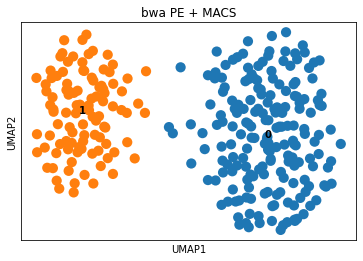

In [13]:
sc.pl.umap(bwa_macs, color='leiden', legend_loc='on data', title='bwa PE + MACS')

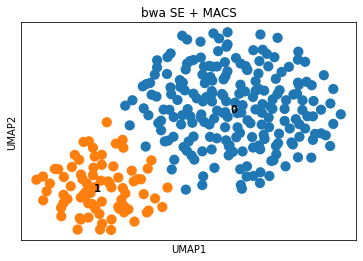

In [14]:
sc.pl.umap(bwa_macs_single, color='leiden', legend_loc='on data', title='bwa SE + MACS')

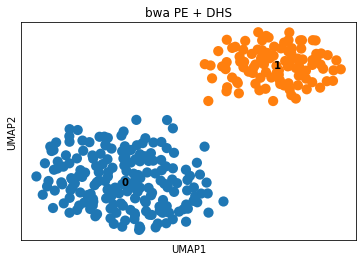

In [15]:
sc.pl.umap(bwa_dhs, color='leiden', legend_loc='on data', title='bwa PE + DHS')

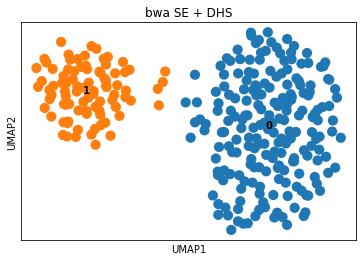

In [16]:
sc.pl.umap(bwa_dhs_single, color='leiden', legend_loc='on data', title='bwa SE + DHS')

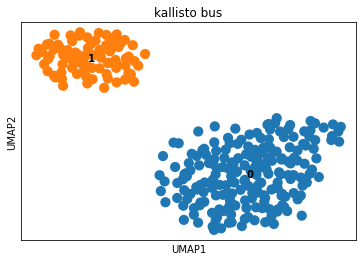

In [17]:
sc.pl.umap(kallisto_bus, color='leiden', legend_loc='on data', title='kallisto bus')

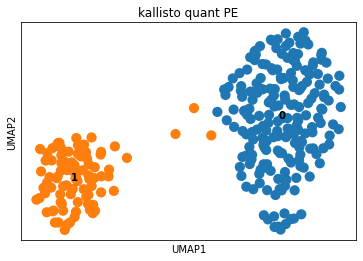

In [18]:
sc.pl.umap(kallisto_quant, color='leiden', legend_loc='on data', title='kallisto quant PE')

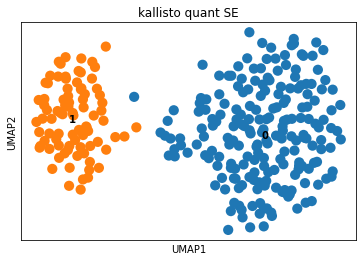

In [19]:
sc.pl.umap(kallisto_quant_single, color='leiden', legend_loc='on data', title='kallisto quant SE')

Adjusted Mutual informations are high, between .68 and .93, two `kallisto` methods give very similar, albeit not equal, results possibly to the fact `quant` uses paired-end reads, while `bus` doesn't. A notable outlier is `bwa SE + MACS`

In [20]:
ami = []
datasets = [bwa_macs, bwa_macs_single, bwa_dhs, bwa_dhs_single, kallisto_bus, kallisto_quant, kallisto_quant_single]
for x in range(len(datasets) - 1):
    for y in range(x + 1, len(datasets)):
        ami.append(sklearn.metrics.adjusted_mutual_info_score(datasets[x].obs['leiden'], datasets[y].obs['leiden']))

In [21]:
labels = ['bwa PE + MACS', 'bwa SE + MACS', 'bwa PE + DHS', 'bwa SE + DHS', 'kallisto bus', 'kallisto quant PE', 'kallisto quant SE']

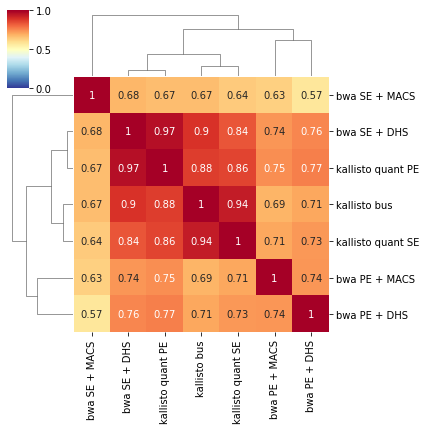

In [22]:
sqami = scipy.spatial.distance.squareform(ami)
sqami[np.diag_indices_from(sqami)] = 1        
sns.clustermap(pd.DataFrame(sqami, index=labels, columns=labels), vmin=0, vmax=1, cmap='RdYlBu_r', annot=True, figsize=(6,6))

Coming to differential regions, we test all regions in all experiment, so that we can compare fold-changes as well 

In [23]:
sc.tl.rank_genes_groups(kallisto_bus, method='wilcoxon', groupby='leiden', n_genes=kallisto_bus.shape[1])
sc.tl.rank_genes_groups(kallisto_quant, method='wilcoxon', groupby='leiden', n_genes=kallisto_quant.shape[1])
sc.tl.rank_genes_groups(kallisto_quant_single, method='wilcoxon', groupby='leiden', n_genes=kallisto_quant.shape[1])
sc.tl.rank_genes_groups(bwa_dhs, method='wilcoxon', groupby='leiden', n_genes=bwa_dhs.shape[1])
sc.tl.rank_genes_groups(bwa_dhs_single, method='wilcoxon', groupby='leiden', n_genes=bwa_dhs_single.shape[1])
sc.tl.rank_genes_groups(bwa_macs, method='wilcoxon', groupby='leiden', n_genes=bwa_macs.shape[1])
sc.tl.rank_genes_groups(bwa_macs_single, method='wilcoxon', groupby='leiden', n_genes=bwa_macs_single.shape[1])

In [24]:
def intvl2bed(s, as_string=False):
    c_string = s.replace(':', '\t').replace('-', '\t')
    if as_string:
        return c_string
    chrom, start, end = c_string.split()
    return [chrom, int(start), int(end)]

To compare results, we select regions that are significant at adjusted p-value < 0.01. Note that, since we have two groups, the regions marking group `'0'` are the mirrored in group `'1'`, except they will have inverse fold-changes. We wil only focus on group `'0'`, then, making sure the group is always matched across experiments 

In [25]:
thr = 0.01

In [26]:
adata = bwa_macs
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

bwa_macs_regions = regions

In [27]:
adata = bwa_macs_single
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

bwa_macs_single_regions = regions

In [28]:
adata = bwa_dhs
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

bwa_dhs_regions = regions

In [29]:
adata = bwa_dhs_single
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

bwa_dhs_single_regions = regions

In [30]:
adata = kallisto_bus
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

kallisto_bus_regions = regions

In [31]:
adata = kallisto_quant
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

kallisto_quant_regions = regions

In [32]:
adata = kallisto_quant_single
groups = adata.obs['leiden'].cat.categories
regions = dict.fromkeys(groups)
adj_p = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
fc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
for g in groups:
    mask = adj_p[g] < thr
    l = pd.DataFrame([intvl2bed(x) for x in names[g][mask]], columns=['Chromosome', 'Start', 'End'])
    l['Score'] = fc[g][mask]
    regions[g] = pr.PyRanges(l)

kallisto_quant_single_regions = regions

In [33]:
def jaccard_range(a, b):
    i_len = len(a.set_intersect(b))
    u_len = len(a.set_union(b))
    return (i_len / u_len, i_len, u_len)

First we will compare results by jaccard score over intervals: all values are included between 0.56 and 0.83. Similarity of `bwa`-based strategies with `kallisto`-based strategies suggest that the major driver is not the peak identification itself, but alignment and counting. `bwa SE + MACS` is again an outlier, possibly due to spurious peaks identified by `MACS` when single reads are used.

In [34]:
jaccards = []
r_datasets = [bwa_macs_regions, bwa_macs_single_regions, bwa_dhs_regions, bwa_dhs_single_regions, kallisto_bus_regions, kallisto_quant_regions, kallisto_quant_single_regions]
datasets = [bwa_macs, bwa_macs_single, bwa_dhs, bwa_dhs_single, kallisto_bus, kallisto_quant, kallisto_quant_single]
for x in range(len(datasets) - 1):
    for y in range(x + 1, len(datasets)):
        adata1 = datasets[x]
        adata2 = datasets[y]
        ct = pd.crosstab(adata1.obs['leiden'].values, adata2.obs['leiden'].values)
        gr2 = '0'
        gr1 = ct.index[np.argmax(ct[gr2])]
        jaccards.append(jaccard_range(r_datasets[x][gr1], r_datasets[y][gr2])[0])

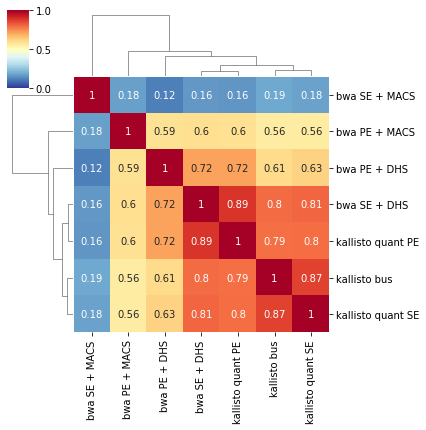

In [35]:
sqj= scipy.spatial.distance.squareform(jaccards)
sqj[np.diag_indices_from(sqj)] = 1
sns.clustermap(pd.DataFrame(sqj, index=labels, columns=labels), vmin=0, vmax=1, cmap='RdYlBu_r', annot=True, figsize=(6,6))

Lastly we compare the foldchanges of all peaks (not only the significant) among strategies which are, in general, very high and included between 0.66 and 0.91. This has not been included in the paper, but it may be interesting as well.

In [36]:
spearman_r = []
r_datasets = [bwa_macs_regions, bwa_macs_single_regions, bwa_dhs_regions, bwa_dhs_single_regions, kallisto_bus_regions, kallisto_quant_regions, kallisto_quant_single_regions]
datasets = [bwa_macs, bwa_macs_single, bwa_dhs, bwa_dhs_single, kallisto_bus, kallisto_quant, kallisto_quant_single]
for x in range(len(datasets) - 1):
    for y in range(x + 1, len(datasets)):
        adata1 = datasets[x]
        adata2 = datasets[y]
        ct = pd.crosstab(adata1.obs['leiden'].values, adata2.obs['leiden'].values)
        gr2 = '0'
        gr1 = ct.index[np.argmax(ct[gr2])]

        names = pd.DataFrame(adata1.uns['rank_genes_groups']['names'])
        fc = pd.DataFrame(adata1.uns['rank_genes_groups']['logfoldchanges'])[gr1]
        l = pd.DataFrame([intvl2bed(x) for x in names[gr1]], columns=['Chromosome', 'Start', 'End'])
        l['Score'] = fc
        regions1 = pr.PyRanges(l)

        names = pd.DataFrame(adata2.uns['rank_genes_groups']['names'])
        fc = pd.DataFrame(adata2.uns['rank_genes_groups']['logfoldchanges'])[gr2]
        l = pd.DataFrame([intvl2bed(x) for x in names[gr2]], columns=['Chromosome', 'Start', 'End'])
        l['Score'] = fc
        regions2 = pr.PyRanges(l)

        ovlp = regions1.join(regions2)
        XY = ovlp.as_df().loc[:, ['Score', 'Score_b']]
        spearman_r.append(scipy.stats.spearmanr(XY.values[:, 0], XY.values[:, 1])[0])

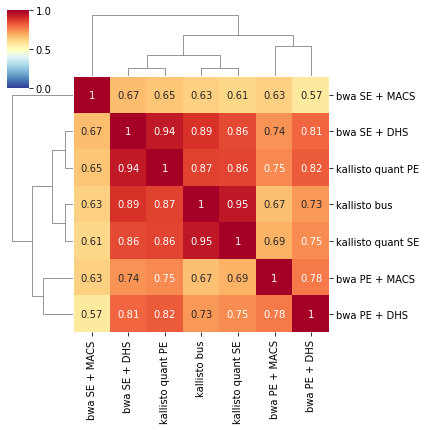

In [37]:
sqspear= scipy.spatial.distance.squareform(spearman_r)
sqspear[np.diag_indices_from(sqspear)] = 1
sns.clustermap(pd.DataFrame(sqspear, index=labels, columns=labels), vmin=0, vmax=1, cmap='RdYlBu_r', annot=True, figsize=(6,6))